In [24]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import pandas as pd
import keras
from keras.utils import FeatureSpace
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# Data Prep

In [2]:
shots_df = pd.read_csv('/content/combined_games/shots_23-24.csv') #import data
shots_df = shots_df[shots_df['shotWasOnGoal'] != 0] #removed misses
shots_df = shots_df[['arenaAdjustedXCordABS','arenaAdjustedYCordAbs','goal', 'shotType','shotRebound']] #reduced to data points of interest

In [3]:
# Replace 'SNAP' and 'WRAP' with 'WRIST'
shots_df['shotType'] = shots_df['shotType'].replace(['SNAP', 'WRAP'], 'WRIST')

# Replace 'DEFL' with 'TIP'
shots_df['shotType'] = shots_df['shotType'].replace('DEFL', 'TIP')

In [4]:
encoder = LabelEncoder()
shots_df['shotType'] = shots_df['shotType'].astype(str)
shots_df['shotType'] = encoder.fit_transform(shots_df['shotType'])

In [5]:
val_shots_df = shots_df.sample(frac=0.2)
train_shots_df = shots_df.drop(val_shots_df.index)

In [7]:
def dataframe_to_dataset(shots_df):
    shots_df = shots_df.copy()
    labels = shots_df.pop("goal")
    ds = tf.data.Dataset.from_tensor_slices((dict(shots_df), labels))
    ds = ds.shuffle(buffer_size=len(shots_df))
    return ds
train_ds = dataframe_to_dataset(train_shots_df)
val_ds = dataframe_to_dataset(val_shots_df)
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [8]:
feature_space = FeatureSpace(
    features={
        "shotType": "integer_categorical",
        "shotRebound": "integer_categorical",
        "arenaAdjustedXCordABS": "float_normalized",
        "arenaAdjustedYCordAbs": "float_normalized",
    },
    output_mode="concat",
)

In [9]:
train_ds_with_no_labels = train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

In [10]:
for x, _ in train_ds.take(1):
    preprocessed_x = feature_space(x)

In [11]:
preprocessed_train_ds = train_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_train_ds = preprocessed_train_ds.prefetch(tf.data.AUTOTUNE)

preprocessed_val_ds = val_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_val_ds = preprocessed_val_ds.prefetch(tf.data.AUTOTUNE)

# Model Training

In [12]:
dict_inputs = feature_space.get_inputs()
encoded_features = feature_space.get_encoded_features()

x = keras.layers.Dense(32, activation="relu")(encoded_features)
x = keras.layers.Dropout(0.2)(x)
predictions = keras.layers.Dense(1, activation="sigmoid")(x)

training_model = keras.Model(inputs=encoded_features, outputs=predictions)
training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

shot_evaluator = keras.Model(inputs=dict_inputs, outputs=predictions)

In [13]:
training_model.fit(
    preprocessed_train_ds,
    epochs=20,
    validation_data=preprocessed_val_ds,
    verbose=0,
)

In [33]:
shot_type_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

print(shot_type_mapping)

{'BACK': np.int64(0), 'SLAP': np.int64(1), 'TIP': np.int64(2), 'WRIST': np.int64(3), 'nan': np.int64(4)}


In [35]:
sample = {
   'shotType': 3,
   'shotRebound': 0,
   'arenaAdjustedXCordABS': 85,
   'arenaAdjustedYCordAbs': 0
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = shot_evaluator.predict(input_dict)

print(
    f"This shot has a {100 * predictions[0][0]:.2f}% chance of going in."
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
This shot has a 23.49% chance of going in.


# Game Scoring Helper Functions

In [62]:
def load_shot_data(csv_path_or_content):
    #Load shot data from either a file path or CSV content string
    try:
        df = pd.read_csv(csv_path_or_content)
    except (FileNotFoundError, pd.errors.EmptyDataError):
        lines = csv_path_or_content.strip().split('\n')
        if not lines:
            raise ValueError("Empty CSV content")

        columns = lines[0].split(',')
        data = []
        for line in lines[1:]:
            values = line.split(',')
            if len(values) == len(columns):
                row = {col: val for col, val in zip(columns, values)}
                data.append(row)

        df = pd.DataFrame(data)

    required_columns = ['Team', 'Player', 'arenaAdjustedXCordABS', 'arenaAdjustedYCordABS',
                         'shotType', 'shotRebound', 'event']

    for required_col in required_columns:
        col_found = False
        for col in df.columns:
            if col.lower() == required_col.lower():
                if col != required_col:
                    df = df.rename(columns={col: required_col})
                col_found = True
                break

        if not col_found:
            raise ValueError(f"Required column '{required_col}' is missing from the data")

    # Convert numeric columns to appropriate types
    numeric_cols = ['arenaAdjustedXCordABS', 'arenaAdjustedYCordABS', 'shotRebound']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

In [63]:
# Extract UA players from player column
def extract_ua_players(player_str):
    return [p for p in re.split(r'\s+', player_str) if p.strip()]

In [64]:
def predict_shot_probability(model, shot_data):
    shot_type = shot_data.get('shotType', shot_data.get('SHOTTYPE', 'WRIST'))

    shot_rebound = int(shot_data.get('shotRebound', shot_data.get('SHOTREBOUND', 0)))
    x_coord = float(shot_data.get('arenaAdjustedXCordABS', shot_data.get('ARENAADJUSTEDXCORDABS', 0)))
    y_coord = abs(float(shot_data.get('arenaAdjustedYCordAbs',
                              shot_data.get('arenaAdjustedYCordABS',
                                    shot_data.get('ARENAADJUSTEDYCORDABS', 0)))))

    # Map shotType string to numeric value using mapping
    if isinstance(shot_type, str):
        shot_type_value = shot_type_mapping.get(shot_type, 0)
    else:
        shot_type_value = int(shot_type)

    sample = {
        'shotType': shot_type_value,
        'shotRebound': shot_rebound,
        'arenaAdjustedXCordABS': x_coord,
        'arenaAdjustedYCordAbs': y_coord
    }

    # Convert to tensor
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}


    predictions = model.predict(input_dict, verbose=0)

    # Return probability as a float
    return float(predictions[0][0])

In [80]:
def analyze_expected_goals(shot_data, model):
    required_columns = ['Team', 'Player', 'arenaAdjustedXCordABS', 'arenaAdjustedYCordABS',
                        'shotType', 'shotRebound', 'event']

    for col in required_columns:
        if col not in shot_data.columns:
            raise ValueError(f"Required column '{col}' is missing from the data")


    shot_data = shot_data.copy()


    shot_data['xG'] = 0.0

    for idx, row in shot_data.iterrows():
        try:
            shot_data.at[idx, 'xG'] = predict_shot_probability(model, row)
        except Exception as e:
            print(f"Error predicting for row {idx}: {e}")
            shot_data.at[idx, 'xG'] = 0.0

    # Convert actual goals to binary
    shot_data['actualGoal'] = shot_data['event'].apply(lambda x: 1 if x.lower() == 'goal' else 0)

    # Extract all unique UA players
    all_ua_players = set()
    for player_str in shot_data['Player']:
        players = extract_ua_players(str(player_str))
        all_ua_players.update(players)


    player_stats = {player: {'xGF': 0, 'xGA': 0, 'GF': 0, 'GA': 0, 'TOI': 0} for player in all_ua_players}

    # Calculate expected goals for and against each UA player
    for _, shot in shot_data.iterrows():
        team = shot['Team']
        xg = shot['xG']
        actual_goal = shot['actualGoal']

        # Get all UA players on ice for this shot
        ua_players_on_ice = extract_ua_players(str(shot['Player']))

        for player in ua_players_on_ice:
            player_stats[player]['TOI'] += 1

        # Update expected goals stats based on which team took the shot
        if team == 'UA':  # UA taking the shot (for)
            for player in ua_players_on_ice:
                player_stats[player]['xGF'] += xg
                player_stats[player]['GF'] += actual_goal
        else:  # UAH taking the shot (against)
            for player in ua_players_on_ice:
                player_stats[player]['xGA'] += xg
                player_stats[player]['GA'] += actual_goal

    # Convert to DataFrame with explicit columns to avoid errors
    columns = ['player', 'xGF', 'xGA', 'GF', 'GA', 'TOI']
    rows = []
    for player, stats in player_stats.items():
        rows.append([player, stats['xGF'], stats['xGA'], stats['GF'], stats['GA'], stats['TOI']])

    result_df = pd.DataFrame(rows, columns=columns)

    # Calculate net expected goals
    result_df['Net_xG'] = result_df['xGF'] - result_df['xGA']
    result_df['Net_G'] = result_df['GF'] - result_df['GA']

    # Calculate xG percentage: xGF / (xGF + xGA)
    result_df['xG_pct'] = (result_df['xGF'] / (result_df['xGF'] + result_df['xGA']).replace(0, 0.00001) * 100).round(1)

    # Calculate per-appearance rates (avoid division by zero)
    result_df['xGF_per_TOI'] = (result_df['xGF'] / result_df['TOI'].replace(0, 1)).round(3)
    result_df['xGA_per_TOI'] = (result_df['xGA'] / result_df['TOI'].replace(0, 1)).round(3)
    result_df['Net_xG_per_TOI'] = (result_df['Net_xG'] / result_df['TOI'].replace(0, 1)).round(3)

    # Sort by Net_xG
    result_df = result_df.sort_values(by=['Net_xG'], ascending=False)

    return result_df, shot_data

In [84]:
def output_summary(csv_path_or_content, model):
    shot_data = load_shot_data(csv_path_or_content)

    print("Columns in loaded data:", shot_data.columns.tolist())

    if 'arenaAdjustedYCordAbs' not in shot_data.columns and 'arenaAdjustedYCordABS' in shot_data.columns:
        shot_data['arenaAdjustedYCordAbs'] = shot_data['arenaAdjustedYCordABS']

    player_xg_stats, enriched_shot_data = analyze_expected_goals(shot_data, model)

    print("\nUA Player Expected Goals Summary:")
    print("--------------------------------")
    # Print DataFrame without index
    blankIndex=[''] * len(player_xg_stats)
    player_xg_stats.index=blankIndex

    print(player_xg_stats[['player', 'xGF', 'xGA', 'Net_xG', 'GF', 'GA', 'Net_G', 'xG_pct','TOI']])

    team_totals = enriched_shot_data.groupby('Team').agg(
        Total_xG=('xG', 'sum'),
        Total_Goals=('actualGoal', 'sum'),
        Total_Shots=('xG', 'count')
    ).reset_index()

    print("\nTeam Totals:")
    print(team_totals)

    print("\nTop UA Players by Expected Goals For:")
    print(player_xg_stats.sort_values(by='xGF', ascending=False)[['player', 'xGF', 'GF', 'TOI', 'xGF_per_TOI']].head(5))

    print("\nTop UA Players by Expected Goals Against (Lower is Better):")
    print(player_xg_stats.sort_values(by='xGA_per_TOI', ascending=True)[['player', 'xGA', 'GA', 'TOI', 'xGA_per_TOI']].head(5))

    # Best overall players by net xG per TOI- TOI calculated by proxy from shots while on
    print("\nTop UA Players by Net Expected Goals per TOI:")
    print(player_xg_stats.sort_values(by='Net_xG_per_TOI', ascending=False)[['player', 'Net_xG', 'Net_G', 'TOI', 'Net_xG_per_TOI']].head(5))

     # Best overall players by xG percentage
    print("\nTop UA Players by Expected Goals Percentage (xG%):")
    print(player_xg_stats.sort_values(by='xG_pct', ascending=False)[['player', 'xGF', 'xGA', 'xG_pct', 'TOI']].head(5))
    return player_xg_stats

In [87]:
def plot_top_xg_percentage(player_stats_df, num_players=5, figsize=(10, 6), title="Top Players by Expected Goals Percentage"):
    # Sort by xG percentage and get top players
    top_players = player_stats_df.sort_values(by='xG_pct', ascending=False).head(num_players)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    colors = sns.color_palette("Blues", len(top_players))

    bars = ax.bar(
        top_players['player'],
        top_players['xG_pct'],
        color=colors,
        width=0.6
    )

    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height + 1,  # Position slightly above the bar
            f'{height:.1f}%',
            ha='center',
            va='bottom',
            fontweight='bold'
        )


    # Customize the plot
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel('Player Number', fontsize=12, labelpad=15)
    ax.set_ylabel('Expected Goals Percentage (%)', fontsize=12)


    max_value = top_players['xG_pct'].max()
    ax.set_ylim(0, max_value * 1.15)  # Add 15% padding at the top

    # Add a horizontal line at 50% for reference
    ax.axhline(y=50, color='red', linestyle='--', alpha=0.7, linewidth=1)
    ax.text(len(top_players)-1, 51, '50%', color='red', ha='right', fontsize=10)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add a light grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Adjust bottom margin to make room for TOI text
    plt.subplots_adjust(bottom=0.15)

    plt.tight_layout()

    return fig

# Game Scoring: UA vs. UT

In [85]:
stats = output_summary('/content/individual_games/UA vs UAH 10-28.csv', shot_evaluator)

Columns in loaded data: ['Team', 'Player', 'arenaAdjustedXCordABS', 'arenaAdjustedYCordABS', 'Distance', 'event', 'shotType', 'shotRebound']

UA Player Expected Goals Summary:
--------------------------------
 player       xGF       xGA    Net_xG  GF  GA  Net_G  xG_pct  TOI
     24  2.224629  0.555219  1.669410   3   0      3    80.0   23
     88  1.559712  0.122894  1.436818   2   0      2    92.7   16
     27  1.892703  0.517702  1.375002   3   0      3    78.5   18
     61  1.302633  0.039451  1.263181   3   0      3    97.1   11
     19  2.224629  1.013605  1.211023   3   0      3    68.7   27
     67  1.405271  0.381428  1.023843   2   0      2    78.7   17
     23  1.846435  0.892933  0.953502   3   0      3    67.4   21
      3  1.557702  0.610688  0.947014   2   0      2    71.8   18
      9  1.606969  0.770516  0.836453   2   0      2    67.6   20
     10  1.667790  0.853870  0.813920   2   0      2    66.1   19
     22  1.383321  0.610688  0.772633   2   0      2    69.4   16

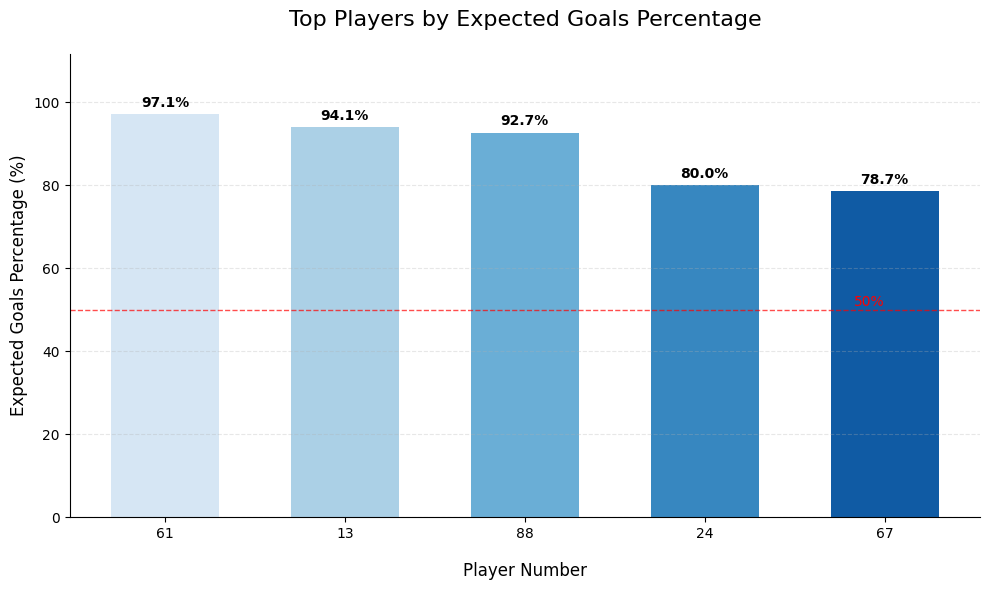

In [88]:
xgplot = plot_top_xg_percentage(stats)
plt.show()